In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from exp.nb_02 import *
import torch.nn.functional as F

## Initial setup

In [3]:
def get_data2():
    mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
                 get_items = get_image_files,
                 splitter = GrandparentSplitter('training', 'testing'),
                 get_y = parent_label)
    dls = mnist.dataloaders(untar_data(URLs.MNIST))
    x_train, y_train = zip(*dls.train_ds)
    x_valid, y_valid = zip(*dls.valid_ds)
    
    x_train = tensor(list(map(array, x_train)), dtype=torch.float32).view(len(dls.train_ds), -1)
    x_valid = tensor(list(map(array, x_valid)), dtype=torch.float32).view(len(dls.valid_ds), -1)
    y_train = tensor(y_train)
    y_valid = tensor(y_valid)
    
    x_mean = x_train.mean()
    x_std = x_train.std()
    x_train, x_valid = normalize(x_train, x_mean, x_std), normalize(x_valid, x_mean, x_std)
    x_train, x_valid = x_train / 255.0, x_valid / 255.0
    
    return x_train, y_train, x_valid, y_valid

In [4]:
x_train, y_train, x_valid, y_valid = get_data2()

In [5]:
mpl.rcParams['image.cmap'] = 'gray'

In [6]:
x_train.shape

torch.Size([60000, 784])

In [7]:
n,m = x_train.shape
c = y_train.max() + 1
nh = 50

In [8]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]
        
    def forward(self, x):
        for l in self.layers: x = l(x)
        return x

In [9]:
model = Model(m,nh,10)

In [10]:
pred = model(x_train)
pred.shape

torch.Size([60000, 10])

In [11]:
def log_softmax(x): return (x.exp() / (x.exp().sum(-1, keepdim=True))).log()

In [12]:
sm_pred = log_softmax(pred)
sm_pred.shape

torch.Size([60000, 10])

In [13]:
def log_softmax2(x): return x - x.exp().sum(-1, keepdim=True).log()

In [14]:
sm_pred2 = log_softmax2(pred)
sm_pred2.shape

torch.Size([60000, 10])

In [15]:
test_near(sm_pred, sm_pred2) #fails for some reason; numbers seem to be near

In [16]:
y_train[:5]

tensor([4, 4, 4, 4, 4])

In [17]:
pred.max(-1)[0].shape

torch.Size([60000])

In [18]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x-m[:,None]).exp().sum(-1).log()

In [19]:
logsumexp(pred).shape

torch.Size([60000])

In [20]:
test_near(logsumexp(pred), pred.logsumexp(-1))

In [21]:
def log_softmax(pred): return pred - pred.logsumexp(-1, keepdim=True)

In [22]:
pred.shape, y_train.shape

(torch.Size([60000, 10]), torch.Size([60000]))

In [23]:
def nll(pred, target): return -pred[range(pred.shape[0]), target].mean()

In [24]:
loss = nll(log_softmax(pred), y_train)
loss

tensor(2.3087, grad_fn=<NegBackward>)

In [25]:
test_near(nll(log_softmax(pred), y_train), loss)

In [26]:
test_near(F.nll_loss(F.log_softmax(pred, -1),y_train), loss)

In [27]:
test_near(F.cross_entropy(pred, y_train), loss)

# Basic training loop

In [28]:
loss_func = F.cross_entropy

In [29]:
def accuracy(pred, yb): return (pred.argmax(-1) == yb).float().mean()

In [30]:
bs = 64

In [31]:
xb = x_train[:bs]
preds = model(xb)
preds.shape

torch.Size([64, 10])

In [32]:
preds[0]

tensor([ 0.0882, -0.1238, -0.1182, -0.1098,  0.0734,  0.0093, -0.0544, -0.0886,
         0.0590, -0.1408], grad_fn=<SelectBackward>)

In [33]:
yb = y_train[:bs]

In [34]:
loss_func(preds, yb)

tensor(2.1936, grad_fn=<NllLossBackward>)

In [35]:
accuracy(preds, yb)

tensor(0.)

In [36]:
lr = 0.5
epochs = 1

In [37]:
for epoch in range(epochs):
    for i in range((n-1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias -= l.bias.grad * lr
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()

In [38]:
def loss_and_accuracy(model=None, xb=xb, yb=yb):
    if model is None: model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return loss_func(model(xb) ,yb), accuracy(model(xb), yb)

In [39]:
loss_and_accuracy()

(tensor(2.2903, grad_fn=<NllLossBackward>), tensor(0.))

# Using parameters and optim

In [40]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        
    def __call__(self, x): return self.l2(F.relu(self.l1(x)))

In [41]:
nh

50

In [42]:
m

784

In [43]:
model = Model(m,nh,10)

In [44]:
for name,l in model.named_children(): print(f'{name}: {l}')

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)


In [45]:
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [46]:
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [47]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)
            
            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()

In [48]:
fit()

In [49]:
loss_and_accuracy()

(tensor(2.2531, grad_fn=<NllLossBackward>), tensor(0.))

In [50]:
class DummyModule():
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        
    def __setattr__(self, k, v):
        if not k.startswith('_'): self._modules[k] = v
        super().__setattr__(k,v)
    
    def __repr__(self): return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters(): yield p

In [51]:
mdl = DummyModule(m,nh,10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [52]:
mdl.l1

Linear(in_features=784, out_features=50, bias=True)

In [53]:
[p.shape for p in mdl.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

## Registering modules

In [54]:
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10)]

In [55]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i, l in enumerate(self.layers): self.add_module(f'layer_{i}', l)
            
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [56]:
model = Model(layers)

In [57]:
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

## nn.Modulelist

In [58]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [59]:
model = SequentialModel(layers)

In [60]:
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [61]:
fit()
loss_and_accuracy(model)

(tensor(0.0014, grad_fn=<NllLossBackward>), tensor(1.))

## nn.Sequential

In [62]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [63]:
fit()

In [64]:
loss_and_accuracy()

(tensor(2.2350, grad_fn=<NllLossBackward>), tensor(0.))

In [65]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

## optim

In [120]:
class Optimizer():
    def __init__(self, params, lr=0.5):
        self.params = list(params)
        self.lr = lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= self.lr * p.grad
    
    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [67]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [68]:
opt = Optimizer(model.parameters())

In [69]:
for epoch in range(epochs):
    for i in range((n-1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

In [70]:
loss_and_accuracy()

(tensor(2.3276, grad_fn=<NllLossBackward>), tensor(0.))

In [71]:
from torch import optim

In [122]:
def get_model():
    "return model and optimizer"
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [123]:
lr

0.5

In [135]:
model, opt = get_model()

In [136]:
loss_and_accuracy(model, xb, yb)

(tensor(2.3373, grad_fn=<NllLossBackward>), tensor(0.))

In [137]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [138]:
loss_and_accuracy(model, xb, yb)

(tensor(0.0016, grad_fn=<NllLossBackward>), tensor(1.))

## Dataset

In [139]:
class Dataset():
    def __init__(self, x, y): self.x, self.y = x, y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i]

In [147]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [148]:
len(train_ds)

60000

In [149]:
xb,yb = train_ds[0:5]
assert xb.shape == (5,28*28)
assert yb.shape == (5,)

In [153]:
model, opt = get_model()

In [154]:
loss_and_accuracy(model, xb, yb)

(tensor(2.2691, grad_fn=<NllLossBackward>), tensor(0.))

In [155]:
for epoch in range(epochs):
    for i in range((n-1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

In [156]:
loss_and_accuracy(model, xb, yb)

(tensor(0.0014, grad_fn=<NllLossBackward>), tensor(1.))

## DataLoader

In [157]:
class DataLoader():
    def __init__(self, ds, bs): self.ds, self.bs = ds, bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

In [158]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [177]:
xb, yb = next(iter(train_dl))
assert xb.shape == (bs,28*28)
assert yb.shape == (bs,)

tensor(4)

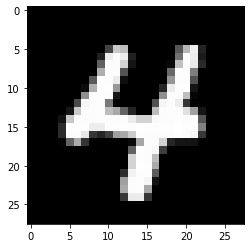

In [178]:
plt.imshow(xb[0].view(28,28))
yb[0]

In [179]:
model, opt = get_model()
loss_and_accuracy(model, xb, yb)

(tensor(2.3846, grad_fn=<NllLossBackward>), tensor(0.))

In [180]:
def fit():
    for epoch in range(epochs):
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            
            loss.backward()
            opt.step()
            opt.zero_grad()

In [181]:
for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

loss_and_accuracy(model, xb, yb)

(tensor(0.0014, grad_fn=<NllLossBackward>), tensor(1.))

In [182]:
fit()
loss_and_accuracy(model, xb, yb)

(tensor(0.0191, grad_fn=<NllLossBackward>), tensor(1.))

## Random Sampling

In [183]:
class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        self.n, self.bs, self.shuffle = len(ds), bs, shuffle
        
    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs): yield self.idxs[i:i+self.bs]

In [184]:
small_ds = Dataset(*train_ds[:10])

In [185]:
s = Sampler(small_ds, 3, False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [186]:
s = Sampler(small_ds, 3, True)
[o for o in s]

[tensor([3, 4, 0]), tensor([2, 8, 5]), tensor([6, 7, 9]), tensor([1])]

In [187]:
def collate(b):
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)

class DataLoader():
    def __init__(self, ds, sampler, collate_fn=collate):
        self.ds, self.sampler, self.collate_fn = ds, sampler, collate_fn
        
    def __iter__(self):
        for s in self.sampler: yield self.collate_fn([self.ds[i] for i in s])

In [188]:
train_samp = Sampler(train_ds, bs, True)
valid_samp = Sampler(valid_ds, bs, False)

In [189]:
train_dl = DataLoader(train_ds, sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, sampler=valid_samp, collate_fn=collate)

In [190]:
xb, yb = next(iter(valid_dl))
assert xb.shape == (bs,28*28)
assert yb.shape ==(bs,)

tensor(0)

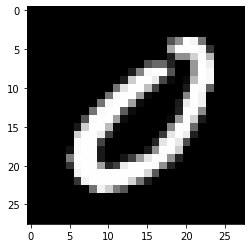

In [191]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(6)

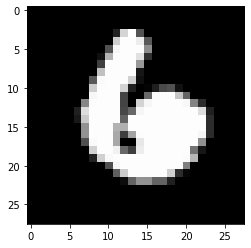

In [192]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [193]:
yb

tensor([6, 4, 9, 7, 8, 1, 7, 4, 8, 3, 1, 5, 3, 4, 7, 1, 6, 4, 3, 5, 6, 0, 8, 7,
        7, 4, 3, 8, 8, 4, 1, 6, 8, 0, 3, 5, 7, 7, 0, 8, 0, 3, 8, 9, 1, 6, 1, 9,
        8, 6, 1, 3, 5, 9, 2, 1, 2, 8, 7, 3, 8, 9, 8, 8])

In [201]:
model,opt = get_model()

In [202]:
fit()
loss_and_accuracy(model, xb, yb)

(tensor(2.1766, grad_fn=<NllLossBackward>), tensor(0.1562))

In [203]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss, acc

(tensor(2.1766, grad_fn=<NllLossBackward>), tensor(0.1562))

## Pytorch DataLoader

In [204]:
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [205]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [206]:
xb.shape

torch.Size([32, 784])

In [207]:
yb.shape

torch.Size([32])

In [208]:
model, opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)
#loss_and_accuracy(model, xb, yb)

(tensor(2.1022, grad_fn=<NllLossBackward>), tensor(0.5000))

In [209]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, bs, shuffle=False)

In [210]:
model, opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(2.1491, grad_fn=<NllLossBackward>), tensor(0.4062))

In [211]:
loss_and_accuracy(model, xb, yb)

(tensor(2.1491, grad_fn=<NllLossBackward>), tensor(0.4062))

# Validation

In [212]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        # Handle batchnorm/dropout
        model.train()
        for xb, yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        model.eval()
        with torch.no_grad():
            tot_loss, tot_acc = 0., 0.
            for xb, yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc += accuracy(pred, yb)
                
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

In [213]:
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, bs, shuffle=True, **kwargs), DataLoader(valid_ds, bs*2, **kwargs))

In [214]:
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)
model, opt = get_model()
loss, acc = fit(5, model, loss_func, opt, train_dl, valid_dl)
loss, acc

0 tensor(2.1161) tensor(0.2315)
1 tensor(1.5227) tensor(0.3544)
2 tensor(0.7997) tensor(0.7334)
3 tensor(0.6309) tensor(0.8041)
4 tensor(0.9118) tensor(0.7033)


(tensor(0.9118), tensor(0.7033))